In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [37]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from prophet import Prophet
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM

from src.features import build_features
from src.models.predict_model import evaluate_metrics, create_prediction_dataframe

warnings.filterwarnings("ignore")

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# Objetivo del cuadernillo

En este cuadernillo se quiere realizar el preprocesamiento de los datos de egresos hospitalarios para confeccionar un modelo de previsión de esta métrica hasta el 2035. De forma general, se utilizarán los datos desde 2001 hasta 2018 para entrenar modelos, y 2019 para evaluar los modelos. Se obviará 2020 del análisis debido a la naturaleza del año (pandemia).

- Se entrenarán 6 modelos distintos, y se seleccionará el que tenga el mejor desempeño en el conjunto de evaluación (año 2019). Los modelos a entrenar serán:

  - Prophet
  - Auto ARIMA
  - XGB
  - Hibrido
  - Feed Forward Neural Network
  - Long-Short Term Memory (LSTM)

Para simplificar el modelamiento de los datos, se harán las predicciones con una agregación de egresos mensuales.


In [3]:
# Lee la base de datos
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")

# Crea columna de fecha en datetime
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# Elimina columnas redundantes
egresos_torax = egresos_torax.drop(
    columns=[
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
).sort_values("FECHA_EGRESO")

# Elimina el anio 2020, debido a que es anomalo (Pandemia COVID)
egresos_torax = egresos_torax.query("FECHA_EGRESO < '2020-01-01'")

# Elige la fecha como indice de los datos
egresos_torax = egresos_torax.set_index("FECHA_EGRESO")

In [4]:
DIAGS_MAS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

In [5]:
# Obtiene metricas agregadas por mes (suma los egresos de todos los diags por dia)
df = egresos_torax.resample("M").sum()[["n_egresos"]]
df_relevantes = (
    egresos_torax[egresos_torax["DIAG1"].isin(DIAGS_MAS_RELEVANTES)]
    .resample("M")
    .sum()[["n_egresos"]]
)

# 1. Preprocesamiento de los datos

Cada uno de los modelos requiere un preprocesamiento distinto de los datos. Por lo tanto, se creará un apartado para cada uno.


In [26]:
# Previo a cualquier preprocesamiento, se separa en train y test
CORTE_TEST = "2019-01-01"

train = df[df.index < CORTE_TEST]
test = df[df.index >= CORTE_TEST]

# Define time splitter para hacer validacion cruzada
time_splitter = TimeSeriesSplit(n_splits=5, test_size=12)

metricas = {
    "MAE": mean_absolute_error,
    "MAPE": mean_absolute_percentage_error,
}

## Prophet


In [7]:
# Preprocesa datos Prophet
train_prophet = train.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})
test_prophet = test.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})

In [8]:
# Entrena datos en Prophet
prophet = Prophet()
prophet.add_country_holidays("Chile")

# # Define the hyperparameters grid
# param_grid = {
#     "seasonality_mode": ["additive", "multiplicative"],
#     "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
#     # Add more hyperparameters here to tune
# }

# prophet = GridSearchCV(
#     estimator=prophet, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=time_splitter
# )
prophet.fit(train_prophet)

09:18:20 - cmdstanpy - INFO - Chain [1] start processing
09:18:21 - cmdstanpy - INFO - Chain [1] done processing


Train
MAE: 27.53
MAPE: 0.07

Test
MAE: 35.46
MAPE: 0.08



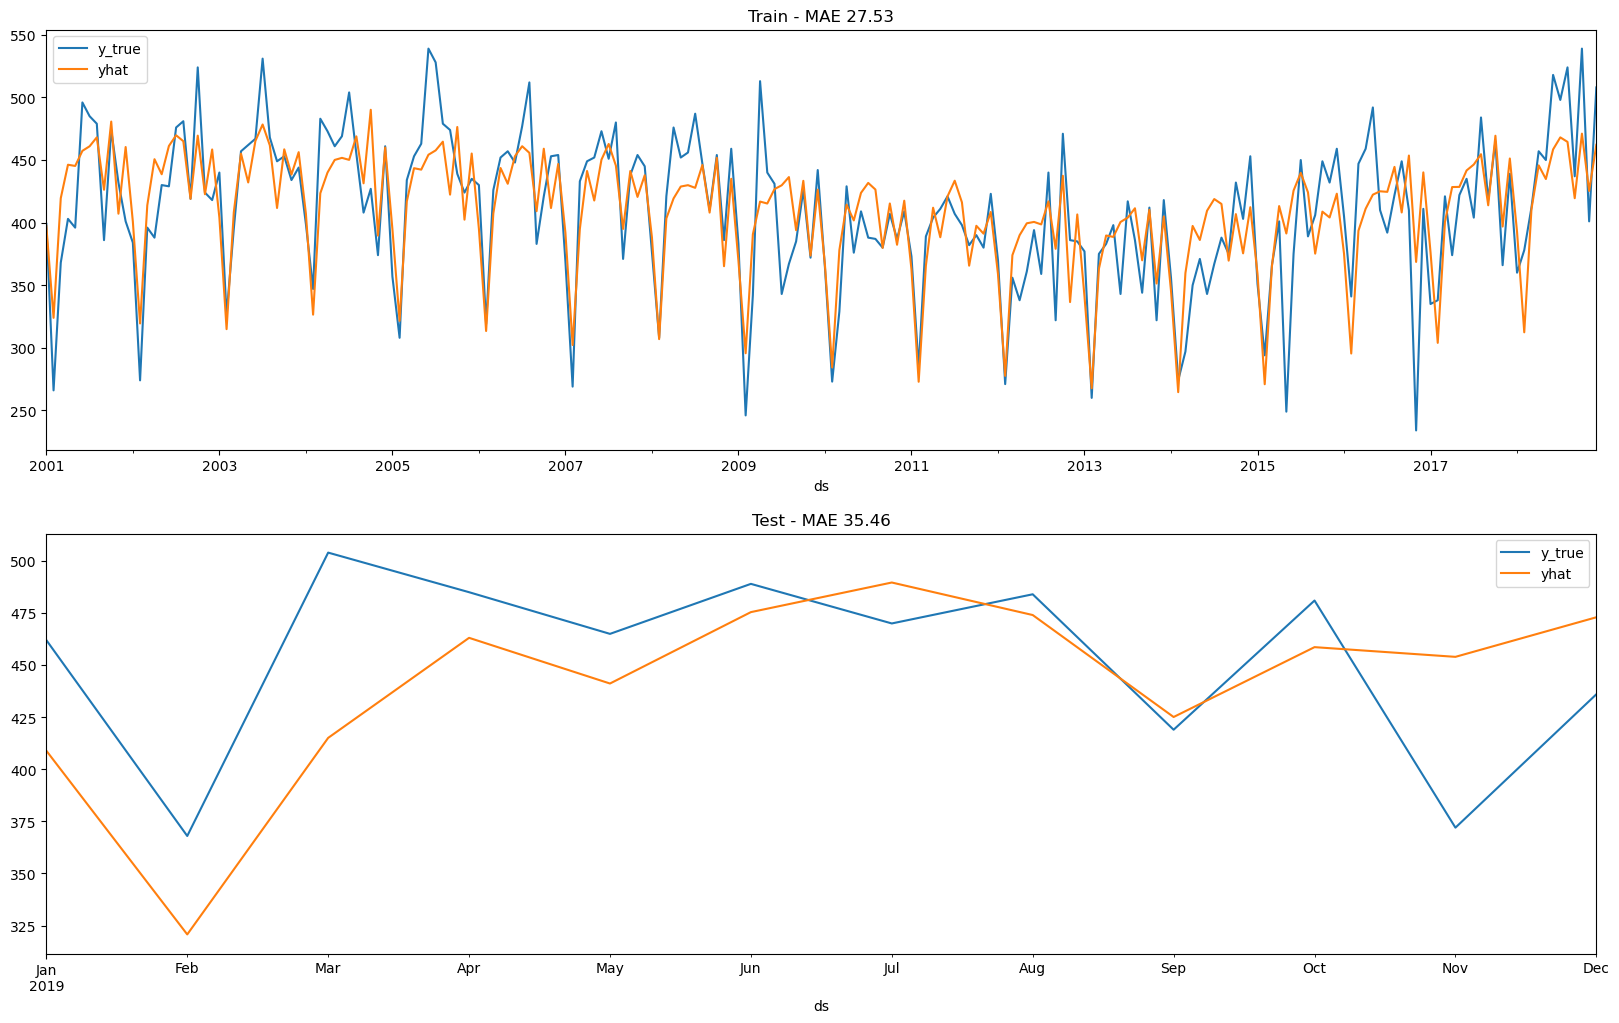

In [46]:
# Predice en conjunto de entrenamiento y testeo
yhat_train_prophet = prophet.predict(train_prophet)["yhat"]
yhat_test_prophet = prophet.predict(test_prophet)["yhat"]

# Evalua rendimiento en conjunto de entrenamiento y testeo
print("Train")
resultados_train_prophet = evaluate_metrics(metricas, train_prophet["y"], yhat_train_prophet)
print("Test")
resultados_test_prophet = evaluate_metrics(metricas, test_prophet["y"], yhat_test_prophet)

# Crea DataFrame con el valor real y predicho
df_train_yhat_prophet = create_prediction_dataframe(
    train_prophet["ds"], train_prophet["y"], yhat_train_prophet
)
df_test_yhat_prophet = create_prediction_dataframe(
    test_prophet["ds"], test_prophet["y"], yhat_test_prophet
)

# Grafica valores reales y predichos
fig, axis = plt.subplots(2, 1, figsize=(20, 12))

df_train_yhat_prophet.plot(ax=axis[0])
df_test_yhat_prophet.plot(ax=axis[1])

axis[0].title.set_text(f"Train - MAE {resultados_train_prophet['MAE']}")
axis[1].title.set_text(f"Test - MAE {resultados_test_prophet['MAE']}")

## Auto ARIMA


In [10]:
train_auto_arima = train["n_egresos"]
test_auto_arima = test["n_egresos"]

In [11]:
arima = auto_arima(
    train_auto_arima,
    start_p=1,
    d=1,
    start_q=1,
    max_p=5,
    max_d=5,
    max_q=5,
    m=12,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=5,
    max_D=5,
    max_Q=5,
    seasonal=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    n_fits=50,
    trace=True,
)

print(arima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2152.011, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2239.530, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2155.577, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2084.254, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2153.062, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2084.848, Time=0.31 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2084.881, Time=0.38 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2114.501, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2164.901, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2084.217, Time=0.25 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2084.866, Time=0.37 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2084.834, Time=0.47 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2115.748, Time=0.28 sec
 ARIMA(1,1,1)(1,1,2)[12]

In [12]:
sarimax = SARIMAX(train_auto_arima, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
result_sarimax = sarimax.fit()
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          n_egresos   No. Observations:                  216
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1038.108
Date:                            Wed, 06 Dec 2023   AIC                           2084.217
Time:                                    09:18:28   BIC                           2097.470
Sample:                                01-31-2001   HQIC                          2089.578
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1393      0.090      1.540      0.124      -0.038       0.317
ma.L1         -0.8597      0.042    -20.241      0.000      -0.943      -0.776
ma.S.L12      -0.7569      0.061    -12.321      0.000      -0.877      -0.637
sigma2      1530.0092    123.309     12.408      0.000    1288.327    1771.691
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                75.74
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAE train: 34.48 egresos - MAPE train: 0.09
MAE test: 32.34 egresos - MAPE test: 0.07


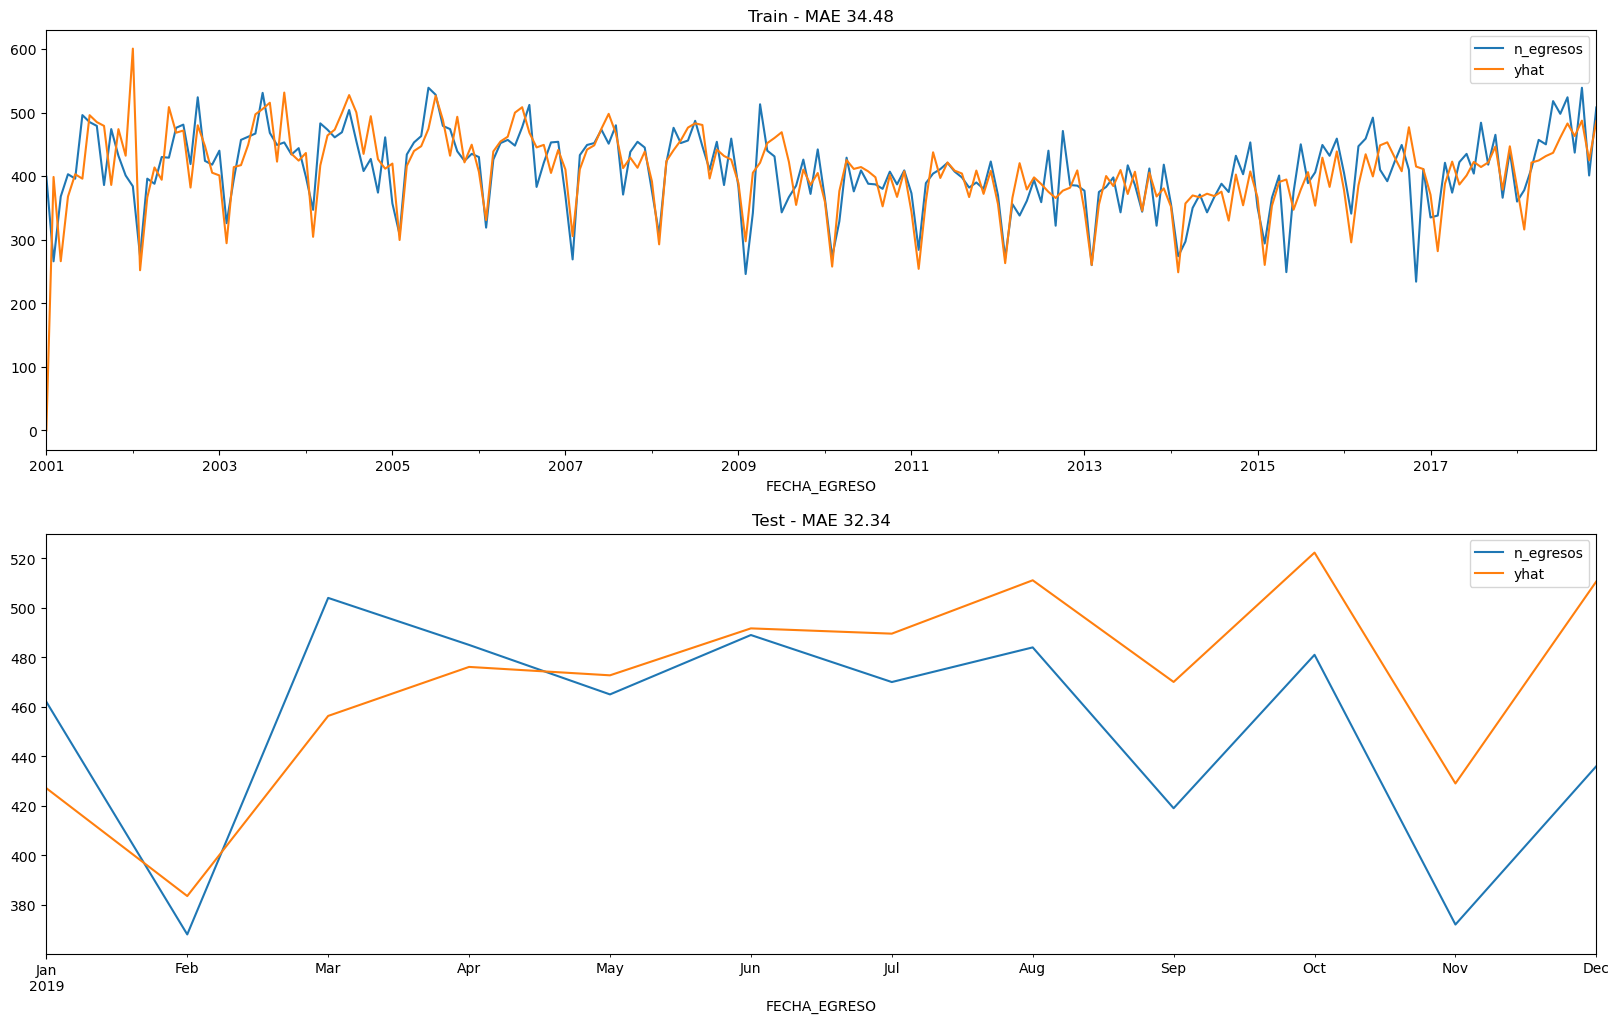

In [13]:
# Evalua metricas de rendimiento en train y test
start_index = 0
end_index = len(train_auto_arima) - 1
yhat_train_sarimax = result_sarimax.predict(start_index, end_index)

start_index = len(train_auto_arima)
end_index = start_index + len(test_auto_arima) - 1
yhat_test_sarimax = result_sarimax.predict(start_index, end_index)

mae_train = mean_absolute_error(train_auto_arima, yhat_train_sarimax)
mae_test = mean_absolute_error(test_auto_arima, yhat_test_sarimax)

mape_train = mean_absolute_percentage_error(train_auto_arima, yhat_train_sarimax)
mape_test = mean_absolute_percentage_error(test_auto_arima, yhat_test_sarimax)

print(f"MAE train: {mae_train:.2f} egresos - MAPE train: {mape_train:.2f}")
print(f"MAE test: {mae_test:.2f} egresos - MAPE test: {mape_test:.2f}")

# Grafica rendimiento de modelo
train_auto_arima = train_auto_arima.to_frame()
train_auto_arima["yhat"] = yhat_train_sarimax

test_auto_arima = test_auto_arima.to_frame()
test_auto_arima["yhat"] = yhat_test_sarimax

fig, axis = plt.subplots(2, 1, figsize=(20, 12))
train_auto_arima.plot(ax=axis[0])
test_auto_arima.plot(ax=axis[1])

axis[0].title.set_text(f"Train - MAE {mae_train:.2f}")
axis[1].title.set_text(f"Test - MAE {mae_test:.2f}")

## XGB


In [14]:
# Agrega los lags significativos segun grafico de autocorrelacion
LAGS_A_AGREGAR = [1, 2, 3, 11, 12, 24]

train_xgb = build_features.add_time_series_columns(train)
train_xgb = build_features.create_lag_features(train_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0)

test_xgb = build_features.add_time_series_columns(test)
test_xgb = build_features.create_lag_features(test_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0)

# Separa en X e y

X_train_xgb = train_xgb.drop(columns="n_egresos")
y_train_xgb = train_xgb["n_egresos"]

X_test_xgb = test_xgb.drop(columns="n_egresos")
y_test_xgb = test_xgb["n_egresos"]

In [15]:
xgb = XGBRegressor()

param_grid_xgb = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="neg_mean_absolute_error",
    cv=time_splitter,
    verbose=10,
    n_jobs=-1,
)


xgb.fit(X_train_xgb, y_train_xgb)
print(xgb.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


MAE train: 11.64 egresos - MAPE train: 0.03
MAE test: 39.66 egresos - MAPE test: 0.09


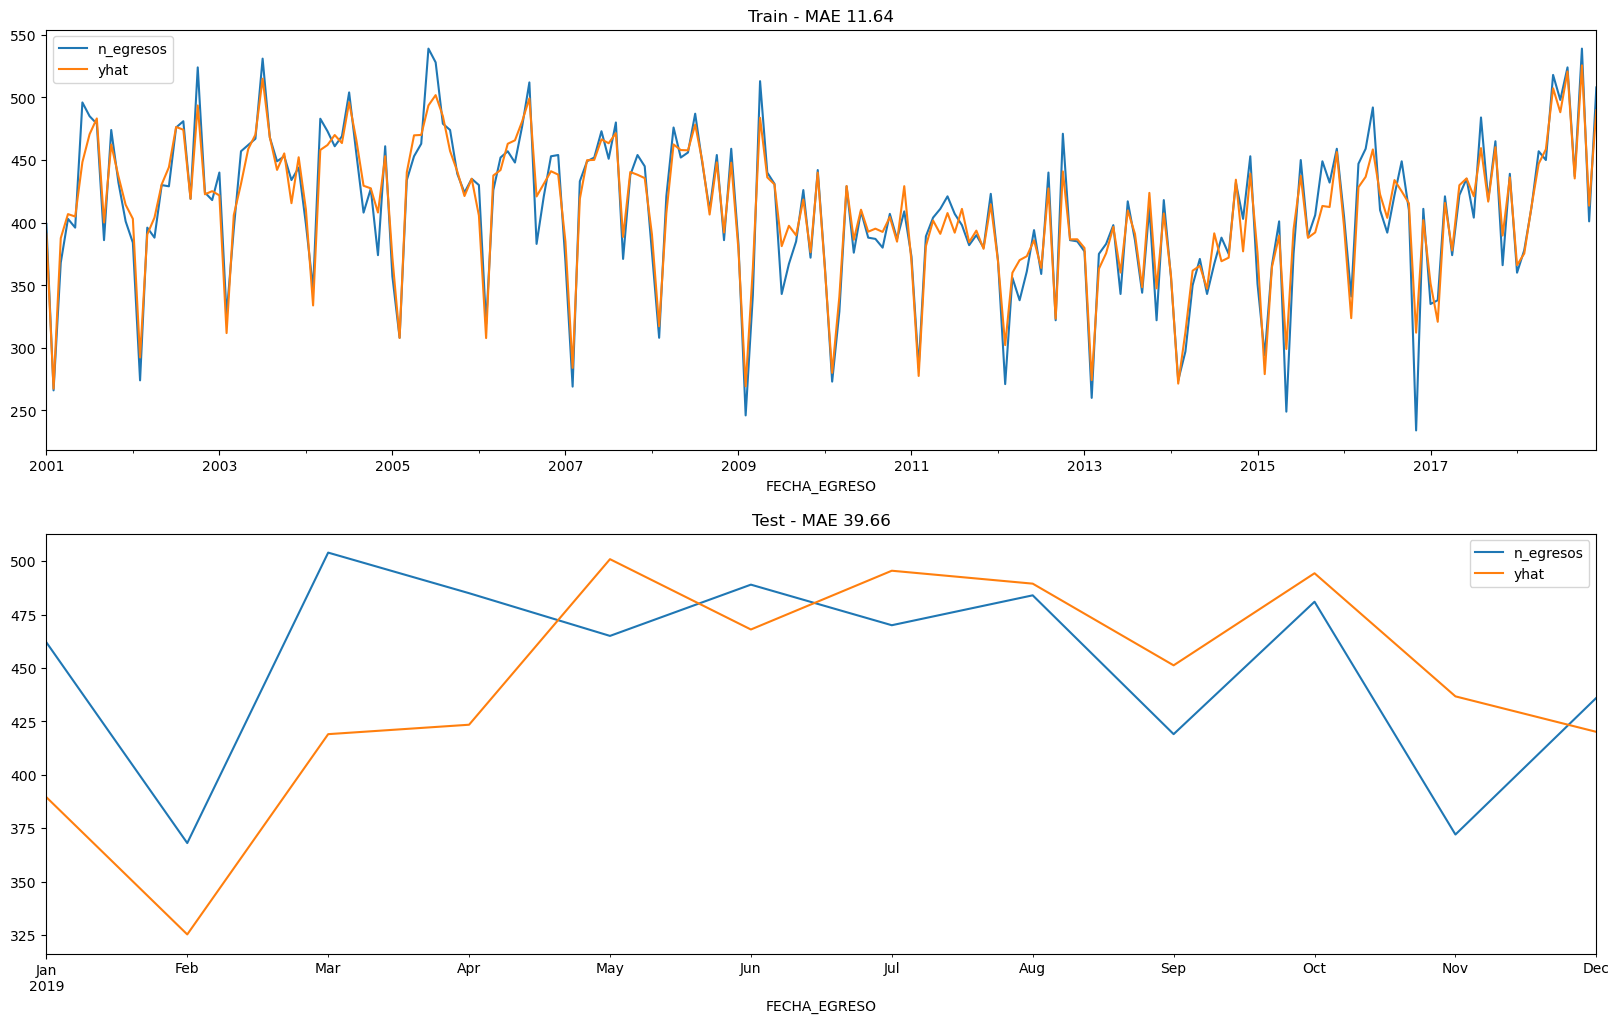

In [16]:
# Evalua metricas de rendimiento en train y test
yhat_train_xgb = xgb.predict(X_train_xgb)
yhat_test_xgb = xgb.predict(X_test_xgb)

mae_train = mean_absolute_error(y_train_xgb, yhat_train_xgb)
mae_test = mean_absolute_error(y_test_xgb, yhat_test_xgb)

mape_train = mean_absolute_percentage_error(y_train_xgb, yhat_train_xgb)
mape_test = mean_absolute_percentage_error(y_test_xgb, yhat_test_xgb)

print(f"MAE train: {mae_train:.2f} egresos - MAPE train: {mape_train:.2f}")
print(f"MAE test: {mae_test:.2f} egresos - MAPE test: {mape_test:.2f}")

# Grafica rendimiento de modelo
train_xgb["yhat"] = yhat_train_xgb
test_xgb["yhat"] = yhat_test_xgb

fig, axis = plt.subplots(2, 1, figsize=(20, 12))
train_xgb.plot(y=["n_egresos", "yhat"], ax=axis[0])
test_xgb.plot(y=["n_egresos", "yhat"], ax=axis[1])

axis[0].title.set_text(f"Train - MAE {mae_train:.2f}")
axis[1].title.set_text(f"Test - MAE {mae_test:.2f}")

## Feed Forward Neural Network


In [17]:
SEQ_SIZE = 3
n_features = 1

train_ff_nn = train.values
test_ff_nn = test.values

X_train_ff_nn, y_train_ff_nn = build_features.to_sequences(train_ff_nn, SEQ_SIZE)
X_test_ff_nn, y_test_ff_nn = build_features.to_sequences(test_ff_nn, SEQ_SIZE)

In [18]:
ff_nn = Sequential(
    [
        Dense(64, activation="relu", input_shape=[SEQ_SIZE]),
        Dense(32, activation="relu"),
        # Dense(32, activation="relu"),
        Dense(1),
    ]
)
ff_nn.compile(loss="mae", optimizer="adam", metrics=["acc"])
print(ff_nn.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [19]:
history_ff_nn = ff_nn.fit(
    X_train_ff_nn,
    y_train_ff_nn,
    validation_data=(X_test_ff_nn, y_test_ff_nn),
    epochs=50,
    steps_per_epoch=10,
)

Epoch 1/50


10/10 [==============================] - 1s 21ms/step - loss: 479.1611 - acc: 0.0000e+00 - val_loss: 439.6195 - val_acc: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 344.5373 - acc: 0.0000e+00 - val_loss: 323.5392 - val_acc: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 0s 3ms/step - loss: 260.4760 - acc: 0.0000e+00 - val_loss: 236.2861 - val_acc: 0.0000e+00
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 172.0039 - acc: 0.0000e+00 - val_loss: 112.8304 - val_acc: 0.0000e+00
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 69.5302 - acc: 0.0000e+00 - val_loss: 36.5501 - val_acc: 0.0000e+00
Epoch 6/50
10/10 [==============================] - 0s 6ms/step - loss: 54.1087 - acc: 0.0000e+00 - val_loss: 50.0680 - val_acc: 0.0000e+00
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 48.0744 - acc: 0.0000e+00 - val_loss: 31.7226 - val_acc: 0.0000e+00
Epoch 8/5

1/1 [==============================] - 0s 17ms/step
MAE train: 44.97 egresos - MAPE train: 0.12
MAE test: 31.10 egresos - MAPE test: 0.07


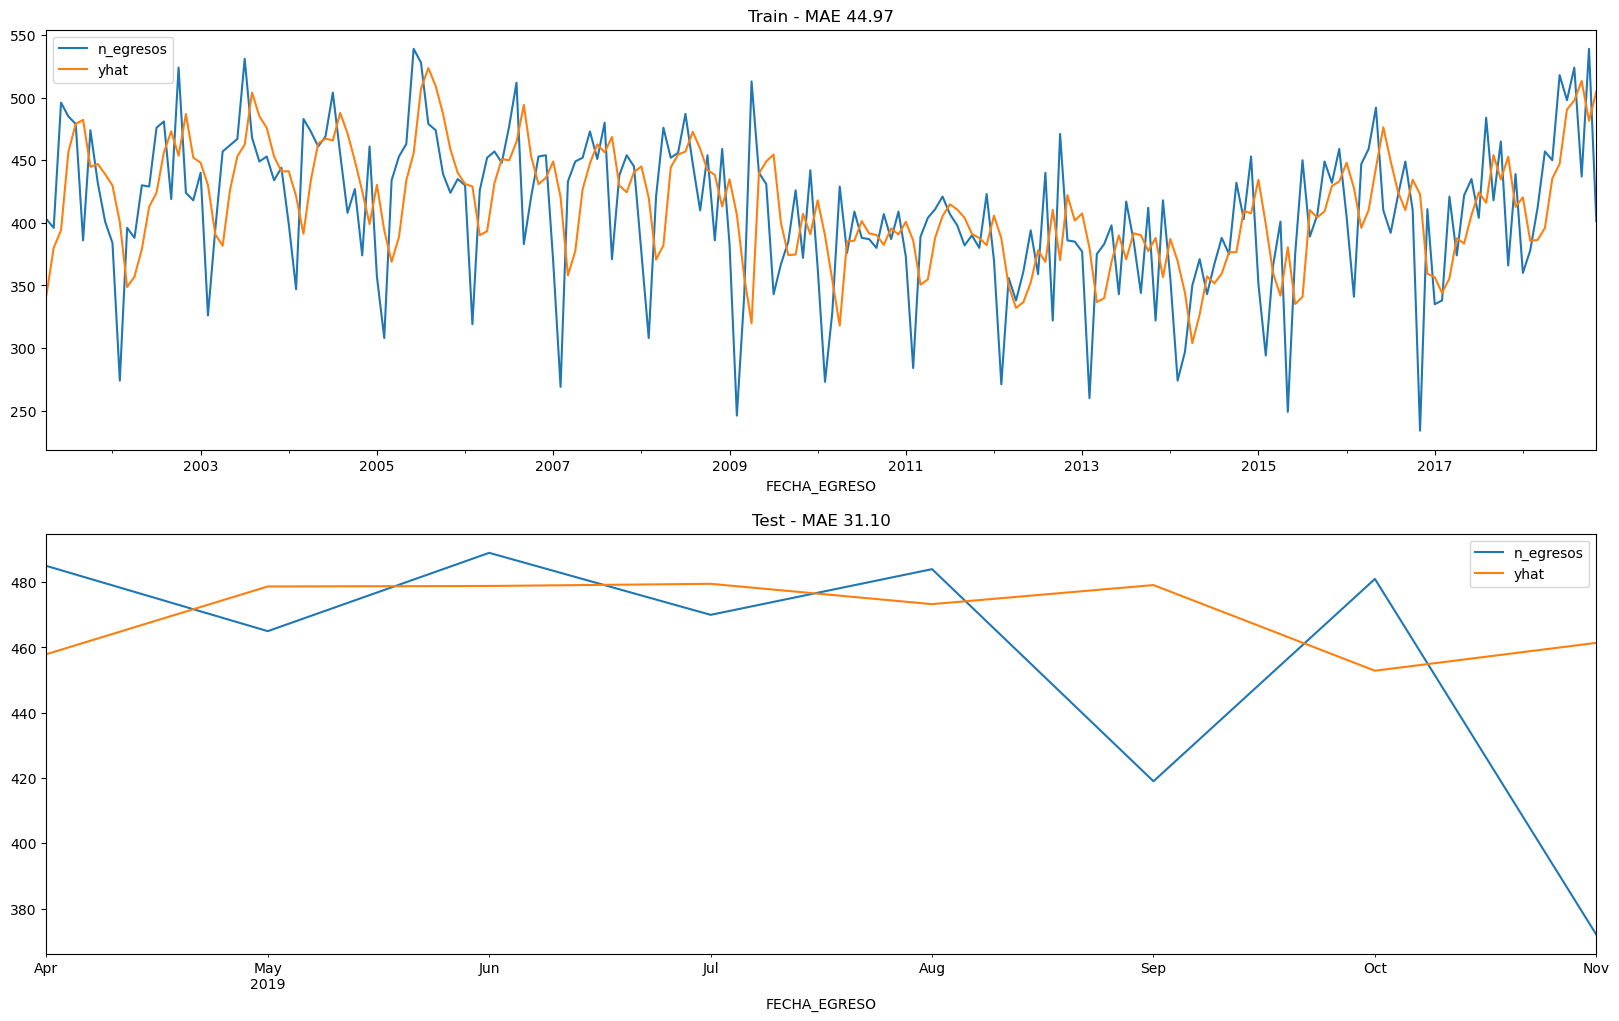

In [20]:
# Evalua metricas de rendimiento en train y test
yhat_train_ff_nn = ff_nn.predict(X_train_ff_nn)
yhat_test_ff_nn = ff_nn.predict(X_test_ff_nn)

mae_train = mean_absolute_error(y_train_ff_nn, yhat_train_ff_nn)
mae_test = mean_absolute_error(y_test_ff_nn, yhat_test_ff_nn)

mape_train = mean_absolute_percentage_error(y_train_ff_nn, yhat_train_ff_nn)
mape_test = mean_absolute_percentage_error(y_test_ff_nn, yhat_test_ff_nn)

print(f"MAE train: {mae_train:.2f} egresos - MAPE train: {mape_train:.2f}")
print(f"MAE test: {mae_test:.2f} egresos - MAPE test: {mape_test:.2f}")

# Grafica rendimiento de modelo
train_ff_nn = pd.DataFrame(
    {
        "n_egresos": train.iloc[SEQ_SIZE : len(yhat_train_ff_nn) + SEQ_SIZE, 0],
        "yhat": yhat_train_ff_nn.reshape(-1),
    }
)

test_ff_nn = pd.DataFrame(
    {
        "n_egresos": test.iloc[SEQ_SIZE : len(yhat_test_ff_nn) + SEQ_SIZE, 0],
        "yhat": yhat_test_ff_nn.reshape(-1),
    }
)

fig, axis = plt.subplots(2, 1, figsize=(20, 12))
train_ff_nn.plot(ax=axis[0])
test_ff_nn.plot(ax=axis[1])

axis[0].title.set_text(f"Train - MAE {mae_train:.2f}")
axis[1].title.set_text(f"Test - MAE {mae_test:.2f}")

## Long Short Term Memory


In [21]:
SEQ_SIZE = 4
n_features = 1

train_lstm = train.values
test_lstm = test.values

X_train_lstm, y_train_lstm = build_features.to_sequences(train_lstm, SEQ_SIZE)
X_test_lstm, y_test_lstm = build_features.to_sequences(test_lstm, SEQ_SIZE)

X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

In [22]:
lstm = Sequential(
    [
        LSTM(32, input_shape=(None, SEQ_SIZE), return_sequences=True, activation="relu"),
        LSTM(16, activation="relu"),
        Dense(16),
        Dense(1),
    ]
)

lstm.compile(loss="mae", optimizer="adam")
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4736      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8161 (31.88 KB)
Trainable params: 8161 (31.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [23]:
history_lstm = lstm.fit(
    X_train_lstm,
    y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=100,
)

Epoch 1/100
7/7 [==============================] - 2s 54ms/step - loss: 439.4170 - val_loss: 480.1910
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 425.9280 - val_loss: 464.8403
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 415.9349 - val_loss: 449.9822
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 399.7060 - val_loss: 432.6089
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 383.2457 - val_loss: 409.8740
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 363.7002 - val_loss: 386.9809
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 341.1675 - val_loss: 356.0586
Epoch 8/100
7/7 [==============================] - 0s 5ms/step - loss: 309.8987 - val_loss: 314.0147
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 268.4696 - val_loss: 259.0052
Epoch 10/100
7/7 [==============================] - 0s 8ms/step - loss: 214.0986 - val_los

1/1 [==============================] - 0s 16ms/step
MAE train: 43.67 egresos - MAPE train: 0.11
MAE test: 36.62 egresos - MAPE test: 0.09


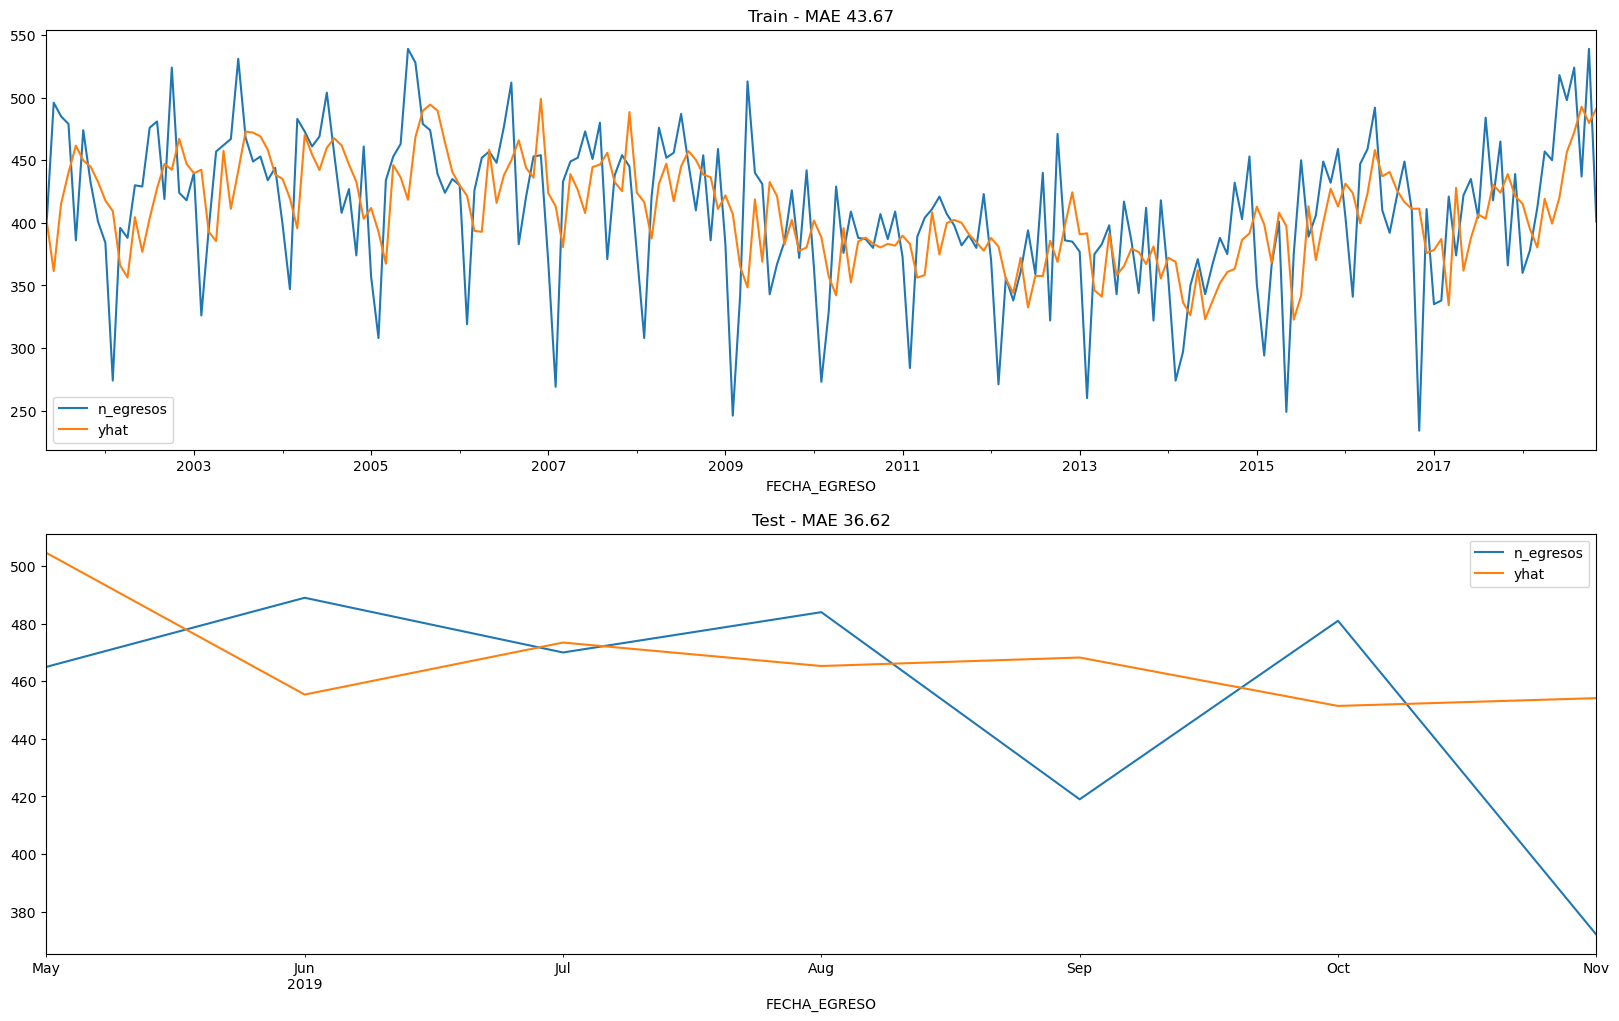

In [24]:
# Evalua metricas de rendimiento en train y test
yhat_train_lstm = lstm.predict(X_train_lstm)

yhat_test_lstm = lstm.predict(X_test_lstm)


mae_train = mean_absolute_error(y_train_lstm, yhat_train_lstm)

mae_test = mean_absolute_error(y_test_lstm, yhat_test_lstm)


mape_train = mean_absolute_percentage_error(y_train_lstm, yhat_train_lstm)

mape_test = mean_absolute_percentage_error(y_test_lstm, yhat_test_lstm)


print(f"MAE train: {mae_train:.2f} egresos - MAPE train: {mape_train:.2f}")

print(f"MAE test: {mae_test:.2f} egresos - MAPE test: {mape_test:.2f}")

# Grafica rendimiento de modelo
train_lstm = pd.DataFrame(
    {
        "n_egresos": train.iloc[SEQ_SIZE : len(yhat_train_lstm) + SEQ_SIZE, 0],
        "yhat": yhat_train_lstm.reshape(-1),
    }
)

test_lstm = pd.DataFrame(
    {
        "n_egresos": test.iloc[SEQ_SIZE : len(yhat_test_lstm) + SEQ_SIZE, 0],
        "yhat": yhat_test_lstm.reshape(-1),
    }
)

fig, axis = plt.subplots(2, 1, figsize=(20, 12))
train_lstm.plot(ax=axis[0])
test_lstm.plot(ax=axis[1])

axis[0].title.set_text(f"Train - MAE {mae_train:.2f}")
axis[1].title.set_text(f"Test - MAE {mae_test:.2f}")